In [ ]:
#  from google.colab import drive
#  drive.mount('/content/drive')

In [ ]:
import os
import zipfile

# Extract zip file
local_ref = '/content/dataset.zip'
zip_ref = zipfile.ZipFile(local_ref, 'r')
zip_ref.extractall('/content/tmp')
zip_ref.close()

# Model Buidling

In [ ]:
import pandas as pd
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import skimage
from skimage.feature import Cascade
from google.colab import files
from tensorflow.keras.preprocessing import image

In [ ]:
class PersonDetectionModel():
  """Combine the face detection capabilities and 
     face classification capabilties under one class"""

  def __init__(self):
    self.model = None

  def extract_faces(self, image):
    # Load the trained file from the module root.
    trained_file = skimage.data.lbp_frontal_face_cascade_filename()
    # Initialize the detector cascade.
    detector = Cascade(trained_file)
    detected = detector.detect_multi_scale(img=image,
    scale_factor=1.2,
    step_ratio=1,
    min_size=(10, 10),
    max_size=(200, 200))

    extracted_faces = []
    for patch in detected:
      face_img = []
      if patch['r'] > 20:
        face_img = image[patch['r']-20:patch['r']+patch['height']+20,patch['c']:patch['c']+patch['width']]
      if patch['r'] < 20 and patch['r'] > 10:
        face_img = image[patch['r']-10:patch['r']+patch['height']+10,patch['c']:patch['c']+patch['width']]
      if patch['r'] < 10:
        face_img = image[patch['r']:patch['r']+patch['height'],patch['c']:patch['c']+patch['width']]
      if len(face_img) == -0:
        continue
      extracted_faces.append(face_img)
    
    return extracted_faces

  def create_face_dir(self, images_dir, target_dir):
    for image_fname in os.listdir(images_dir):
      # upload image
      try:
        img = plt.imread(os.path.join(images_dir,image_fname))
      except:
        print('Could not upload images!')
        break
      extracted_faces = self.extract_faces(img)
      fname = str(image_fname).split('/')[-1].split('.')[0] + '.jpg'
      for i, face in enumerate(extracted_faces):
        if i<1:
          plt.imsave(os.path.join(target_dir,fname), face)
        else:
          fname1 = fname.split('.')[0] + f"({i})." + f'jpg'
          plt.imsave(os.path.join(target_dir,fname1), face)

  def prepare_face_dir(self, main_dir, main_target_dir):
    label_dirs = os.listdir(main_dir)
    for i, label in enumerate(label_dirs):
      label_face_dir = os.path.join(main_target_dir, label)
      os.mkdir(label_face_dir)
      self.create_face_dir(os.path.join(main_dir,label), label_face_dir)
      print(f"Created face directory for {label}")
    
    
  def fit(self, main_dir, validation_split=0.2, augmentation=True, optimizer='rmsprop',
                                          epochs=100, batch_size=32, plot_training=True, faces_directory= None):
    if faces_directory:
      pass
    else:
      faces_directory = os.getcwd() + '/tmp_face/'
      try:
        os.mkdir(faces_directory)
      except FileExistsError:
        shutil.rmtree(os.path.join(faces_directory))
        os.mkdir(faces_directory)
      self.prepare_face_dir(main_dir, faces_directory)

    # TRAINING
    TRAINING_DIR = faces_directory
    if augmentation == True:
      train_datagen = ImageDataGenerator(rescale = 1./255.,
                                            rotation_range = 20,
                                            width_shift_range = 0.2,
                                            height_shift_range = 0.2,
                                            shear_range = 0.2,
                                            zoom_range = 0.4,
                                            horizontal_flip = True,
                                            fill_mode = 'nearest',
                                            validation_split = validation_split # Validation split
                                        )
    else:
      train_datagen = ImageDataGenerator(rescale = 1./255,
                                          validation_split = validation_split)

    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        target_size=(150, 150),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='training')

    validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                            target_size=(150,150),
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            subset='validation')
    
    num_class = len(os.listdir(faces_directory))
    self.model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                            # tf.keras.layers.MaxPooling2D(2,2),
                            # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            # tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(2048, activation='relu'),
                            tf.keras.layers.Dropout(0.4),
                            tf.keras.layers.Dense(num_class, activation='softmax')
    ])


    self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

    hisotry = self.model.fit(train_generator,
                                epochs=epochs,
                                validation_data=validation_generator,
                                verbose=2,
                                )
    
    # PLotting
    if plot_training==True:
      history = hisotry
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(len(acc))
      # Accuracy
      plt.plot(epochs, acc, 'r', label='Training accuracy')
      plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
      plt.title('Training and validation accuracy')
      plt.legend(loc=0)
      plt.figure()
      plt.show()
      # Loss
      plt.plot(epochs, loss, 'r', label='Training loss')
      plt.plot(epochs, val_loss, 'b', label='Validation loss')
      plt.title('Training and validation Loss')
      plt.legend(loc=0)
      plt.figure()
      plt.show()
    
    # Save model
    self.model.save('FaceDetectionModel.h5')

  def predict_by_upload(self, is_face=False):
    
    if self.model == None:
      print("Model hasn't been trained yet!")
      sys.exit()  
    
    uploaded = files.upload()

    for fn in uploaded.keys():
      # predicting images
      path = fn
      print(path)
      plt.imshow(path)
      plt.show()
      img = image.load_img(path, target_size=(150, 150))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)

      images = np.vstack([x])

      
      if is_face:
        faces = np.array([face  for img in images for face in self.extract_face(img)])
        classes = self.model.predict(faces, batch_size=10)
      else:
        classes = self.model.predict(images, batch_size=10)
      print(fn)
      print(classes)

In [ ]:
main_dir = '/content/tmp/images/'
faces_dir = '/content/tmp_face/' # dont give this argument when running first time
#face_directory = main_dir # when you want to train on whole images and not only on faces
split = 0.2
augment = False
opt = 'rmsprop'
epochs = 20
batch_size = 20
plots = True

# TRaining Possibilities


1.   *Extract Faces for the first time*. Do not give **faces_dir** parameter.
2.   *Use already extracted faces*. Give the extracted faces directory path to the **faces_dir** parameter.
3.   *Use original images*. Give original images directory path(same as **main_dir**) to the **faces_dir** parameter. 



Found 465 images belonging to 15 classes.
Found 111 images belonging to 15 classes.
Epoch 1/20
24/24 - 4s - loss: 2.7439 - acc: 0.0667 - val_loss: 2.6899 - val_acc: 0.1081
Epoch 2/20
24/24 - 3s - loss: 2.7030 - acc: 0.0667 - val_loss: 2.6955 - val_acc: 0.0811
Epoch 3/20
24/24 - 3s - loss: 2.7005 - acc: 0.0989 - val_loss: 2.6712 - val_acc: 0.0721
Epoch 4/20
24/24 - 3s - loss: 2.6859 - acc: 0.1032 - val_loss: 2.6335 - val_acc: 0.0991
Epoch 5/20
24/24 - 3s - loss: 2.6328 - acc: 0.1226 - val_loss: 2.5815 - val_acc: 0.1351
Epoch 6/20
24/24 - 3s - loss: 2.5189 - acc: 0.1699 - val_loss: 2.4999 - val_acc: 0.1892
Epoch 7/20
24/24 - 3s - loss: 2.3168 - acc: 0.2473 - val_loss: 2.5138 - val_acc: 0.2162
Epoch 8/20
24/24 - 3s - loss: 2.0760 - acc: 0.3527 - val_loss: 2.3508 - val_acc: 0.2432
Epoch 9/20
24/24 - 3s - loss: 1.8316 - acc: 0.4022 - val_loss: 2.2541 - val_acc: 0.3153
Epoch 10/20
24/24 - 3s - loss: 1.5551 - acc: 0.5333 - val_loss: 2.3053 - val_acc: 0.3243
Epoch 11/20
24/24 - 3s - loss: 1.25

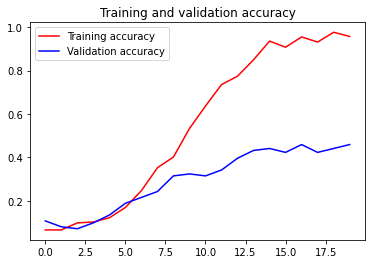

<Figure size 432x288 with 0 Axes>

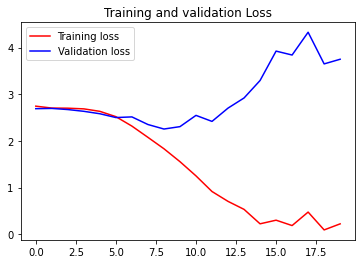

<Figure size 432x288 with 0 Axes>

In [ ]:
model = PersonDetectionModel()
model.fit(main_dir, validation_split=split, augmentation=augment, optimizer=opt,
                                            epochs=epochs, batch_size=batch_size, plot_training=plots, faces_directory=main_dir)

In [ ]:
model.predict_by_upload()

Saving Dhoni.png to Dhoni.png
Dhoni.png
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
